In [1]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.2f}'.format
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import scipy.stats
import pylab
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf

# Extract Data

In [2]:
# get stock data for apple
data = yf.download('AAPL', start = '2015-01-01', end = '2021-01-01')

[*********************100%***********************]  1 of 1 completed


# Setting Up raw data for analysis

In [3]:
#get only 'Adj Close','Volume'
stock = data[['Adj Close','Volume']].copy()

In [4]:
#set higher frequency to business days
stock = stock.asfreq('b')

# Inspecting Price Data 

In [5]:
#check for any nulls
stock.isnull().sum()

Adj Close    54
Volume       54
dtype: int64

In [6]:
stock = stock.fillna(method = 'backfill')

In [7]:
#check for any nulls after fill na has been applied
stock.isnull().sum()

Adj Close    0
Volume       0
dtype: int64

<AxesSubplot:title={'center':'Apple Stock'}, xlabel='Date'>

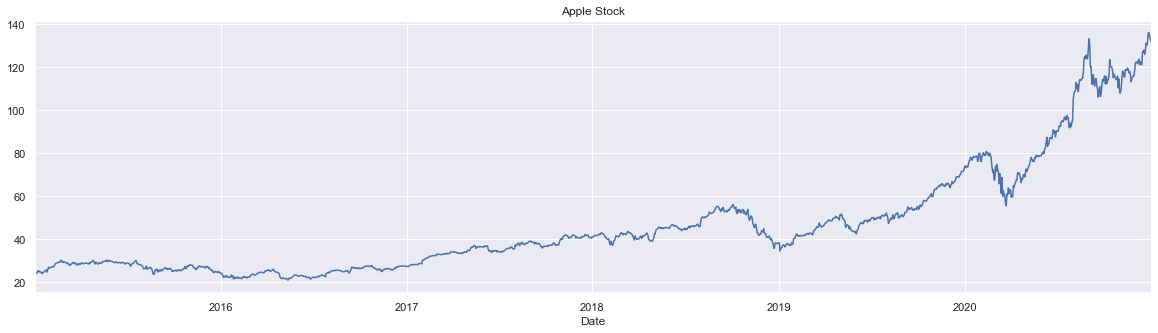

In [8]:
# inspect visually
stock['Adj Close'].plot(figsize = (20,5), title = 'Apple Stock')

In [9]:
# descriptive stats
stock.describe()

,Adj Close,Volume
count,1565.00,1565.00
mean,46.51,145249375.91
std,25.52,71087148.26
min,21.07,45448000.00
25%,27.59,96820400.00
50%,39.82,127727600.00
75%,52.35,174799600.00
max,136.05,648825200.00


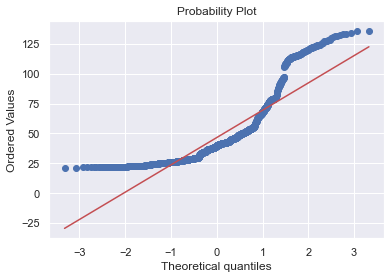

In [10]:
#QQ Plot - How the data fits a normal distribution
scipy.stats.probplot(stock['Adj Close'], plot = pylab)
pylab.show()

In [11]:
#Determining weak form stationarity
sts.adfuller(stock['Adj Close'])

(2.278813940455389,
 0.9989413293313845,
 24,
 1540,
 {'1%': -3.4346033983723516,
  '5%': -2.863418614437511,
  '10%': -2.5677701454714117},
 4806.2184269072995)

# Create AR Model Using % Returns

In [12]:
# Using Returns
stock_r = stock['Adj Close'].pct_change(1).mul(100)
stock_r = stock_r.iloc[1:]
stock_r = stock_r.asfreq('b')
stock_r = stock_r.to_frame('returns')

<AxesSubplot:title={'center':'Apple Returns'}, xlabel='Date'>

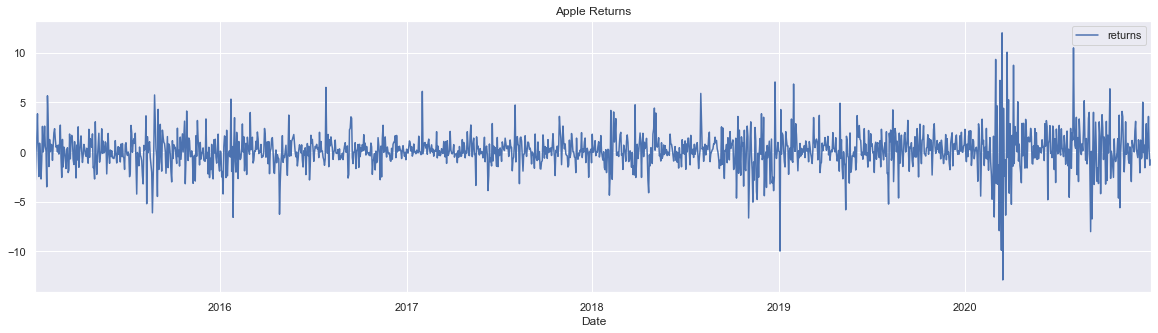

In [13]:
# inspect visually after converted to retunrs
stock_r.plot(figsize = (20,5), title = 'Apple Returns')

In [14]:
#plot a white noise process to compare
#wn = np.random.normal(loc = stock_r.mean(), scale = stock_r.std(), size = len(stock_r))
#stock_r['wn'] = wn

In [15]:
#plot a white noise process and runs tests to compare
#stock_r.wn.plot(figsize = (20,5), title = 'white noise')
#sts.adfuller(stock_r.wn)
#stock_r.drop(['wn'], axis = 1, inplace = True)

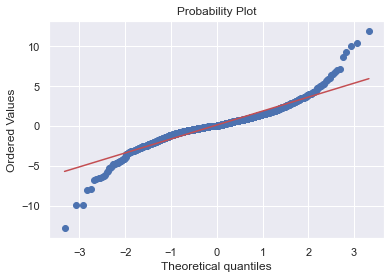

In [16]:
#QQ Plot - How the data fits a normal distribution after transformed to returns
scipy.stats.probplot(stock_r.returns, plot = pylab)
pylab.show()

In [17]:
#Determining weak form stationarity for returns
sts.adfuller(stock_r.returns)
#stock_r.plot(figsize = (20,5), title = 'Apple Stock returns')

(-12.07000245586766,
 2.3598318408489776e-22,
 8,
 1555,
 {'1%': -3.4345623007753496,
  '5%': -2.8634004754910296,
  '10%': -2.567760486450719},
 6190.025724267773)

In [18]:
# descriptive stats of returns
stock_r.describe()

,returns
count,1564.00
mean,0.12
std,1.83
min,-12.86
25%,-0.59
50%,0.04
75%,0.96
max,11.98


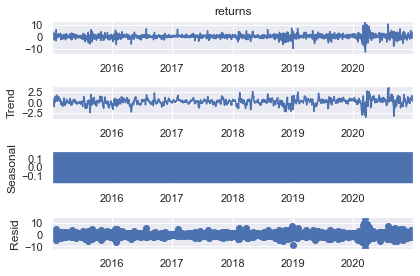

In [19]:
#naive seasonal decomposition --requires at least 2 complete cycles
s_dec_additive = seasonal_decompose(stock_r.returns, model = 'additive')
s_dec_additive.plot()
plt.show()

In [20]:
#naive seasonal decomposition --requires at least 2 complete cycles & not appropiate for 0 or negative values
#s_dec_multiplicative = seasonal_decompose(stock_r, model = 'multiplicative')
#s_dec_additive.plot()
#plt.show()

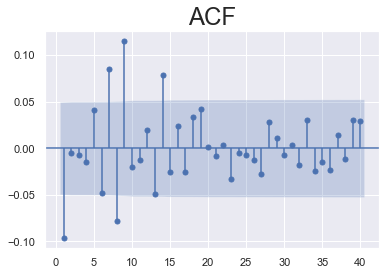

In [21]:
#ACF -- not so important for AR models -- not appropiate for AR models
sgt.plot_acf(stock_r, lags = 40 , zero = False)
plt.title('ACF', size = 24)
plt.show()

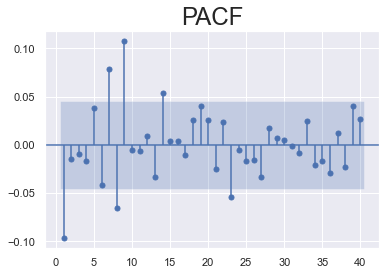

In [22]:
#PACF -- important for AR model -- Appropiate for AR model
sgt.plot_pacf(stock_r, lags = 40 , zero = False, method = ('ld'), alpha=0.07 )
plt.title('PACF', size = 24)
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

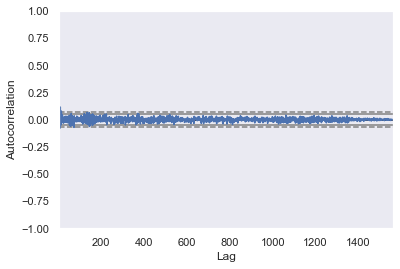

In [23]:
# autocorrelation
autocorrelation_plot(stock_r)

In [24]:
#d & q = 0 makes ARIMA into AR model
model_ar_1 = ARIMA(stock_r, order = (1,0,0))
model_ar_5 = ARIMA(stock_r, order = (5,0,0))
model_ar_6 = ARIMA(stock_r, order = (6,0,0))
model_ar_7 = ARIMA(stock_r, order = (7,0,0))
model_ar_8 = ARIMA(stock_r, order = (8,0,0))
model_ar_9 = ARIMA(stock_r, order = (9,0,0))
model_ar_14 = ARIMA(stock_r, order = (14,0,0))

In [25]:
# fits models
results_ar_1 = model_ar_1.fit()
results_ar_5 = model_ar_5.fit()
results_ar_6 = model_ar_6.fit()
results_ar_7 = model_ar_7.fit()
results_ar_8 = model_ar_8.fit()
results_ar_9 = model_ar_9.fit()
results_ar_14 = model_ar_14.fit()

In [26]:
#LLR (Log Likely Ratio) Test
from scipy.stats import chi2
def LLR_Test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2 - L1))
    P = chi2.sf(LR, DF).round(3)
    return P

In [28]:
print(results_ar_14.summary())
LLR_Test(model_ar_9,model_ar_14)
print('LLR Test P-Value:' + str(LLR_Test(model_ar_9,model_ar_14, DF = 5))) # df = diff of variable between models)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 1564
Model:                ARIMA(14, 0, 0)   Log Likelihood               -3136.852
Date:                Fri, 29 Oct 2021   AIC                           6305.705
Time:                        11:47:40   BIC                           6391.385
Sample:                    01-05-2015   HQIC                          6337.557
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1243      0.051      2.460      0.014       0.025       0.223
ar.L1         -0.0784      0.019     -4.225      0.000      -0.115      -0.042
ar.L2         -0.0290      0.017     -1.666      0.0

# Residuals

In [29]:
#Analyzing residuals 
mod_res = model_ar_9.fit().resid

In [31]:
# mean of residuals
mod_res.describe()

count   1564.00
mean      -0.00
std        1.80
min      -11.11
25%       -0.77
50%       -0.03
75%        0.90
max       10.06
dtype: float64

In [ ]:
#Determining weak form stationarity for residuals
sts.adfuller(mod_res)

In [ ]:
#ACF of residuals for returns
sgt.plot_acf(mod_res, lags = 40 , zero = False)
plt.title('ACF', size = 24)
plt.show()

In [ ]:
mod_res.plot()

# Create AR Models Using Normalized % Returns

In [ ]:
#Create benchmark
benchmark = stock_r.iloc[0]

In [ ]:
#normalize
stock_rn = stock_r.div(benchmark).mul(100)

In [ ]:
#check for stationarity
sts.adfuller(stock_rn)